In [1]:
# Import Libraries
import matplotlib 
# ['pgf', 'Qt4Cairo', 'cairo', 'MacOSX', 'TkCairo',
# 'gdk', 'ps', 'GTKAgg', 'nbAgg', 'GTK', 'Qt5Agg',
# 'template', 'Qt5Cairo', 'WXCairo', 'GTK3Cairo',
# 'GTK3Agg', 'WX', 'Qt4Agg', 'TkAgg', 'agg', 'svg',
# 'GTKCairo', 'WXAgg', 'WebAgg', 'pdf']

# matplotlib.use('nbagg')
matplotlib.use('MacOSX')
%matplotlib notebook

import cv2
import numpy as np
import pandas as pd
import os
import struct
import numpy.matlib
import matplotlib.pyplot as plt
import time
from scipy.fftpack import rfft, rfftfreq, irfft

# import warnings
# warnings.simplefilter('error', RuntimeWarning)

# Headers for different tables
meta_data_header = ['FrameNumber', 'Time', 'Stage_x', 'Stage_y', 'Centroid_x', 'Centroid_y',
                    'Midpoint_x', 'Midpoint_y', 'Head_x', 'Head_y', 'Tail_x', 'Tail_y', 'MouthHook_x', 'MouthHook_y',
                    'LeftMHhook_x', 'LeftMHhook_y', 'RightMHhook_x', 'RightMHhook_y',
                    'LeftDorsalOrgan_x', 'LeftDorsalOrgan_y', 'RightDorsalOrgan_x', 'RightDorsalOrgan_y',
                    'CenterBolwigOrgan_x', 'CenterBolwigOrgan_y', 'LeftBolwigOrgan_x', 'LeftBolwigOrgan_y',
                    'RightBolwigOrgan_x', 'RightBolwigOrgan_y', 'V9_x', 'V9_y', 'V10_x', 'V10_y', 'V11_x', 'V11_y',
                    'V12_x', 'V12_y', 'V13_x', 'V13_y', 'V14_x', 'V14_y', 'V15_x', 'V15_y', 'V16_x', 'V16_y',
                    'MouthHook_votes', 'LeftMHhook_votes', 'RightMHhook_votes', 'LeftDorsalOrgan_votes',
                    'RightDorsalOrgan_votes', 'CenterBolwigOrgan_votes', 'LeftBolwigOrgan_votes', 'RightBolwigOrgan_votes',
                    'V9_votes', 'V10_votes', 'V11_votes', 'V12_votes', 'V13_votes', 'V14_votes', 'V15_votes',
                    'V16_votes', 'Num_Key_points']

coordinate_header = ['FrameNumber', 'MouthHook_x', 'MouthHook_y', 'LeftMHhook_x', 'LeftMHhook_y',
                     'RightMHhook_x', 'RightMHhook_y', 'LeftDorsalOrgan_x', 'LeftDorsalOrgan_y',
                     'RightDorsalOrgan_x', 'RightDorsalOrgan_y', 'CenterBolwigOrgan_x', 'CenterBolwigOrgan_y',
                     'LeftBolwigOrgan_x', 'LeftBolwigOrgan_y', 'RightBolwigOrgan_x', 'RightBolwigOrgan_y']

distance_header = ['MouthHook', 'LeftMHhook',
                   'RightMHhook', 'LeftDorsalOrgan', 'RightDorsalOrgan',
                   'CenterBolwigOrgan', 'LeftBolwigOrgan', 'RightBolwigOrgan']

def readSplineData(fileName, nFrames):
    fCount = 0;
    spline = {}
    with open(fileName, "rb") as f:
        while (True) and (fCount < nFrames-1):
            fCount += 1
            gap, frameNumber = struct.unpack('>ii', f.read(struct.calcsize('>ii')))

            nPointsToRead =  struct.unpack('>i', f.read(struct.calcsize('>i')))
            fmt = ">%dH" % (nPointsToRead)
            tempX = struct.unpack(fmt, f.read(struct.calcsize(fmt)))

            nPointsToRead =  struct.unpack('>i', f.read(struct.calcsize('>i')))
            fmt = ">%dH" % (nPointsToRead)
            tempY = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
            
            spline[frameNumber-1] = np.vstack((np.asarray(tempX).T, np.asarray(tempY).T))

    return spline

def readContourData(fileName, nFrames):    
    fCount = 0;
    contour = {}
    with open(fileName, "rb") as f:
        while (True) and (fCount < nFrames-1):
            fCount += 1
            frameNumber = struct.unpack('>i', f.read(struct.calcsize('>i')))

            nPointsToRead = struct.unpack('>i', f.read(struct.calcsize('>i')))            
            fmt = ">%dH" %(nPointsToRead)
            buff = f.read(struct.calcsize(fmt))
            tempX = struct.unpack(fmt, buff)
            
            nPointsToRead = struct.unpack('>i', f.read(struct.calcsize('>i')))
            fmt = ">%dH" %(nPointsToRead)
            buff = f.read(struct.calcsize(fmt))
            tempY = struct.unpack(fmt, buff)
            
            frameNumber = frameNumber[0]
            contour[frameNumber-1] = np.vstack((np.asarray(tempX).T, np.asarray(tempY).T))

    return contour

def computeHingePointNewTracker(xhead, yhead, xtail, ytail, xspine, yspine):
    if xhead-xtail == 0:
        m = (yhead-ytail)/(xhead+1-xtail);
    else:
        m = (yhead-ytail)/(xhead-xtail);
        
    n = (0.5)*((yhead+ytail)-np.multiply(m, (xhead+xtail)));
    sz = np.shape(xspine)[0]
    m2 = np.matlib.repmat(m, 1, sz);
    n2 = np.matlib.repmat(n, 1, sz);
    distances = np.abs(np.multiply(m, xspine) - yspine + n)/np.sqrt(np.square(m)+1);

    return np.argmax(distances)

# def curvature_splines(x, y=None, error=0.1):
#     """Calculate the signed curvature of a 2D curve at each point
#     using interpolating splines.
#     Parameters
#     ----------
#     x,y: numpy.array(dtype=float) shape (n_points, )
#          or
#          y=None and
#          x is a numpy.array(dtype=complex) shape (n_points, )
#          In the second case the curve is represented as a np.array
#          of complex numbers.
#     error : float
#         The admisible error when interpolating the splines
#     Returns
#     -------
#     curvature: numpy.array shape (n_points, )
#     Note: This is 2-3x slower (1.8 ms for 2000 points) than `curvature_gradient`
#     but more accurate, especially at the borders.
#     """

#     # handle list of complex case
#     if y is None:
#         x, y = x.real, x.imag

#     t = np.arange(x.shape[0])
#     std = error * np.ones_like(x)

#     fx = UnivariateSpline(t, x, k=4, w=1 / np.sqrt(std))
#     fy = UnivariateSpline(t, y, k=4, w=1 / np.sqrt(std))

#     x_d = fx.derivative(1)(t)
#     x_dd = fx.derivative(2)(t)
#     y_d = fy.derivative(1)(t)
#     y_dd = fy.derivative(2)(t)
#     curvature = (x_d* y_dd - y_d* x_dd) / np.power(x_d** 2 + y_d** 2, 1.5)

#     return curvature

def curvature_splines(x, y):
    
    dx  = np.gradient(x);
    ddx = np.gradient(dx);
    dy  = np.gradient(y);
    ddy = np.gradient(dy);
    
    num   = np.multiply(dx, ddy) - np.multiply(ddx, dy)
    denom = np.multiply(dx, dx) + np.multiply(dy, dy);
    denom = np.sqrt(denom);
    
    denom = denom * denom * denom;
    curvature = np.divide(num, denom);
    curvature[denom < 0] = np.nan;

    return curvature

def smooth(y, win_sz):
    box = np.ones(win_sz)/win_sz
    y_smooth = np.convolve(y, box, mode='same')
    y_smooth[-win_sz:] = y[-win_sz:].copy()
    y_smooth[:win_sz] = y[:win_sz].copy()
    
    return y_smooth

def smooth_fft(y, thresh=0.0025):
    N = len(y)
    w = rfft(y)
    f = rfftfreq(N)
    cutoff_idx = f>thresh
    w2 = w.copy()
    w2[cutoff_idx] = 0
    y2 = irfft(w2)
    
    return y2

<IPython.core.display.Javascript object>


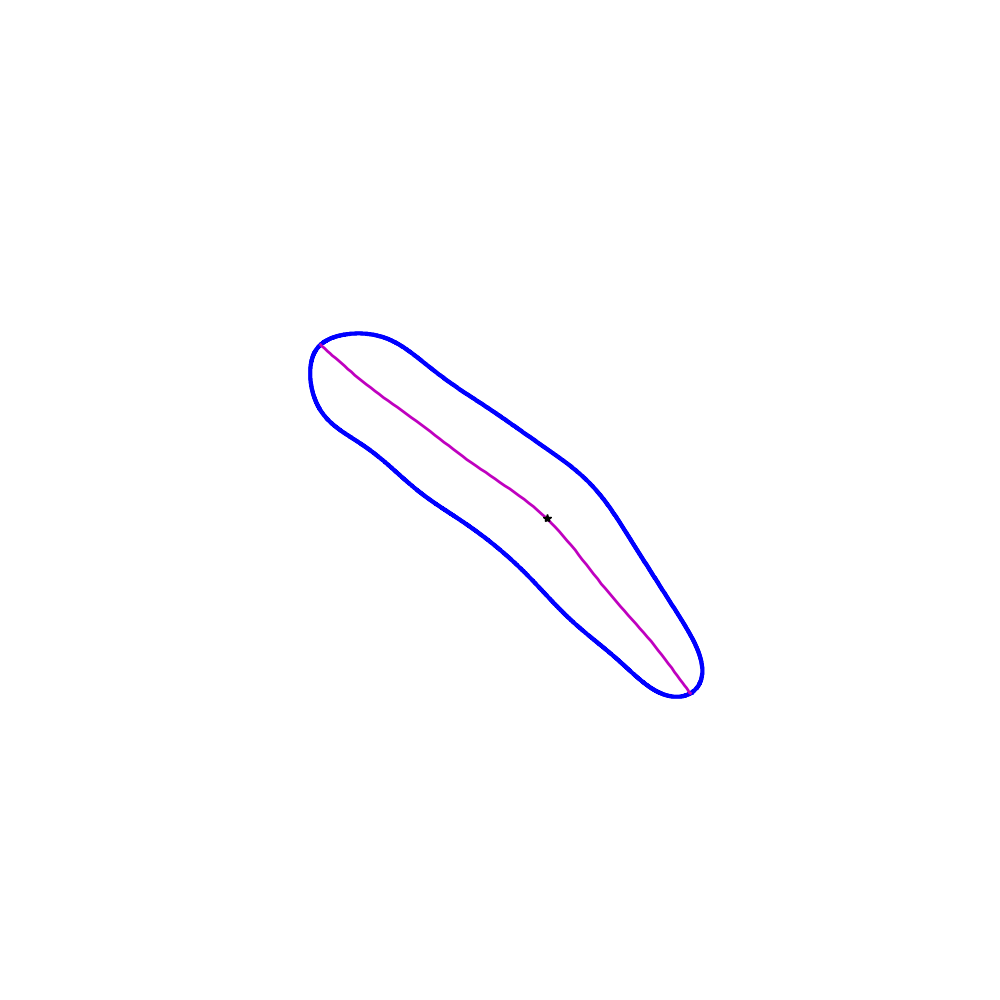

KeyboardInterrupt: 

In [2]:
## 20170317_7c0
# root = '../expts/trainingData_20170317_7c0/'

## 20180417_7c1_Hess_100
# root = '../expts/trainingData_20180417_7c1/'

## 20180417_7c1_Hess_50
# root = '../expts/20180417_7c1_Hess_50/'

## 20180417_7c1_Hess_25
# root = '../expts/20180417_7c1_Hess_25/'

## 20180417_7c1_Hess_100_Nbr_25
# root = '../expts/trainingData_20180417_7c1_Nbr_25/'

## 20180417_7c1_Hess_100_Nbr_25
# root = '../expts/trainingData_20180417_7c1_Nbr_25_ROI_128/'

## 20180417_7c1_Hess_100_ROI_128
# root = '../expts/trainingData_20180417_7c1_Hess_100_ROI_128/'

# 20180417_Individual
# root = '../expts/trainingData_20180417_Individual/'

# 20180417_7c1_Hess_100_BothDO
root = '../expts/trainingData_20180417_7c1_Hess_100_BothDO/'

# test_dir = root + 'dataCollectedOn_20180417_grp_1/Rawdata_20180417_084502_20180423_075225/'
# test_string = "Rawdata_20180417_084502" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_2/Rawdata_20180417_083618_20180420_104633/'
# test_string = "Rawdata_20180417_083618" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_3/Rawdata_20180417_082627_20180525_112343_A_133410/'
# test_string = "Rawdata_20180417_082627" ## Start frame in zero index

test_dir = root + 'dataCollectedOn_20180417_grp_4/Rawdata_20180417_075246_20180420_092232_A_095851/'
test_string = "Rawdata_20180417_075246" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_5/Rawdata_20180417_072307_20180523_100127_A_122116/'
# test_string = "Rawdata_20180417_072307" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_6/Rawdata_20180417_070739_20180522_151012/'
# test_string = "Rawdata_20180417_070739" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_7/Rawdata_20180417_065725_20180522_114055/'
# test_string = "Rawdata_20180417_065725" ## Start frame in zero index

# ## 20170317_7c1
# root = '../expts/trainingData_20170317_7c1/'

# ## 20180417_7c0
# root = '../expts/trainingData_20180417_7c0/'

# 20170318_5c0_test_170317
# root = '../expts/trainingData_20170318_5c0_test_170317/'

# test_dir = root + 'dataCollectedOn_20170317_grp_1/Rawdata_20170317_233847_20170321_034501/'
# test_string = "Rawdata_20170317_233847" ## Start frame in zero index

## Set path to the directory with video file
video_path = '../expts/videos_20180417/'
# video_path = '../expts/videos_20170317/'

video_file = os.path.join(video_path, test_string+".avi")
# video_file = os.path.join(video_path, test_string+".mp4")
test_string_2 = str.split(test_string, '_')[2]

crop_size = 512
spot_size = 18.22
font = cv2.FONT_HERSHEY_SIMPLEX

## Read tracker metadata and annotation
for fs in os.listdir(test_dir):
    if 'Metadata' in fs:
        meta_data = pd.read_csv(os.path.join(test_dir, fs), sep=',', header=0, names=meta_data_header)
    if 'Coordinates' in fs:
        coordinates = pd.read_csv(os.path.join(test_dir, fs), sep=',', names=coordinate_header)

numPoints = len(meta_data.index.values) + 1
for fs in os.listdir(test_dir):
    if 'Contour' in fs:
        contour = readContourData(os.path.join(test_dir, fs), numPoints)
    if 'SPLINE' in fs:        
        spline = readSplineData(os.path.join(test_dir, fs), numPoints)

if (meta_data.empty is False):

    ## OpenCV object for reading video files
    cap = cv2.VideoCapture(video_file)

    ## Total number of videos in the video file
    numberFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    ## Make the metadata frame umber start from 0 index
    meta_data.loc[:, 'FrameNumber'] = meta_data.loc[:, 'FrameNumber'] - 1
    meta_data.set_index('FrameNumber', inplace=True)
    margin = 0
    
    fig,ax = plt.subplots(1,1, figsize=(10, 10))
    ax.set_xlim(0, 2000); ax.set_ylim(0, 2000);
    ax.set_axis_off()
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for frame_num in contour:
        fcontour = contour[frame_num].T.copy()
        fspline = spline[frame_num].T.copy()
        
        head_diff = fcontour - np.reshape(meta_data.loc[frame_num, ['Head_x', 'Head_y']].values, (1, 2))
        head_dist = np.sqrt(np.square(head_diff[:, 0]) + np.square(head_diff[:, 1]))
        head_index = np.argmin(head_dist)
        
        tail_diff = fcontour - np.reshape(meta_data.loc[frame_num, ['Tail_x', 'Tail_y']].values, (1, 2))
        tail_dist = np.sqrt(np.square(tail_diff[:, 0]) + np.square(tail_diff[:, 1]))
        tail_index = np.argmin(tail_dist)
        
        meta_data.loc[frame_num, 'Head_index'] = head_index
        meta_data.loc[frame_num, 'Tail_index'] = tail_index
                
        fcontour = np.roll(fcontour, -head_index, axis=0)
        tail_index = tail_index - head_index
        head_index = 0
        
        thresh=0.004
        fcontour[:, 0] = smooth_fft(fcontour[:, 0], thresh)
        fcontour[:, 1] = smooth_fft(fcontour[:, 1], thresh)
        
#         fspline[:, 0] = smooth(fspline[:, 0], 7)
#         fspline[:, 1] = smooth(fspline[:, 1], 7)
#         fspline_crop = np.zeros(np.shape(fspline[7:-7, :]))
#         fspline_crop[:, 0] = fspline[7:-7, 0].copy()
#         fspline_crop[:, 1] = fspline[7:-7, 1].copy()
#         xhead, yhead = fspline_crop[0, :].copy()
#         xtail, ytail = fspline_crop[-1, :].copy()
#         spline_inflec_index = computeHingePointNewTracker(xhead, yhead, xtail, ytail, fspline_crop[:, 0], fspline_crop[:, 1])
#         spline_inflec_index = spline_inflec_index + 7
        
        curve_1 = fcontour[head_index:tail_index, :].copy()
        curve_2 = fcontour[tail_index+1:, :].copy()

        sub_points_1 = np.array(np.linspace(0, np.shape(curve_1)[0], 101, endpoint=False), dtype=np.int32)
        sub_points_2 = np.array(np.linspace(0, np.shape(curve_2)[0], 101, endpoint=False), dtype=np.int32)

        curve_1_sub = curve_1[sub_points_1, :]
        curve_2_sub = curve_2[sub_points_2, :]
        
        fspline = np.zeros(np.shape(curve_1_sub))
        fspline = (curve_1_sub + np.flip(curve_2_sub, axis=0))/2
        
        fspline_crop = np.zeros(np.shape(fspline[7:-7, :]))
        fspline_crop[:, 0] = fspline[7:-7, 0].copy()
        fspline_crop[:, 1] = fspline[7:-7, 1].copy()
        xhead, yhead = fspline_crop[0, :].copy()
        xtail, ytail = fspline_crop[-1, :].copy()
        spline_inflec_index = computeHingePointNewTracker(xhead, yhead, xtail, ytail, fspline_crop[:, 0], fspline_crop[:, 1])
        spline_inflec_index = spline_inflec_index + 7

        xhead, yhead = curve_1[0, :].copy()
        xtail, ytail = curve_1[-1, :].copy()

        curve_1_inflec_index = computeHingePointNewTracker(xhead, yhead, xtail, ytail, curve_1[:, 0], curve_1[:, 1])
        curve_1_inflec_index = curve_1_inflec_index + head_index

        xhead, yhead = curve_2[0, :].copy()
        xtail, ytail = curve_2[-1, :].copy()

        curve_2_inflec_index = computeHingePointNewTracker(xhead, yhead, xtail, ytail, curve_2[:, 0], curve_2[:, 1])
        curve_2_inflec_index = curve_2_inflec_index + tail_index + 1

        meta_data.loc[frame_num, 'Curve_1_inflec_index'] = curve_1_inflec_index
        meta_data.loc[frame_num, 'Curve_2_inflec_index'] = curve_2_inflec_index

        curv_cont = curvature_splines(contour[frame_num].T[:, 0], contour[frame_num].T[:, 1])

        meta_data.loc[frame_num, 'Curve_1_curv_index'] = curv_cont[curve_1_inflec_index]
        meta_data.loc[frame_num, 'Curve_2_curv_index'] = curv_cont[curve_2_inflec_index]

        ax.plot(fcontour[:, 0], fcontour[:, 1], 'b', lw=3)
        ax.plot(fspline[:, 0], fspline[:, 1], 'm', lw=2)
        ax.plot(fspline[spline_inflec_index, 0], fspline[spline_inflec_index, 1], 'k*', lw=2)
        
        ax.plot(sub_fcontour[spline_inflec_index*2, 0], sub_fcontour[spline_inflec_index*2, 1], 'k*', lw=2)
        ax.plot(curve_1_sub[:, 0], curve_1_sub[:, 1], 'r', lw=3)
        ax.plot(curve_2_sub[:, 0], curve_2_sub[:, 1], 'c', lw=3)
        
        ax.plot(fcontour[curve_1_inflec_index, 0], fcontour[curve_1_inflec_index, 1], 'k*', lw=3)
        ax.plot(fcontour[curve_2_inflec_index, 0], fcontour[curve_2_inflec_index, 1], 'k*', lw=3)     

        ax.set_xlim(0, 2000); ax.set_ylim(0, 2000); ax.set_axis_off();
        fig.canvas.draw()
        time.sleep(1)
        ax.clear()
#         del fcontour, head_diff, head_dist, head_index, tail_diff, tail_dist, tail_index
